In [1]:
# 首先安裝所需的套件
!pip install torch torchvision transformers pillow

In [11]:
# 下載數據集（直接從 Keras 數據集下載）
import tensorflow as tf
dataset_path = tf.keras.utils.get_file(
    "rock_paper_scissors.zip",
    "https://storage.googleapis.com/download.tensorflow.org/data/rps.zip",
    extract=True
)
import pathlib
data_dir = pathlib.Path(dataset_path).parent / "rps"

200682221/200682221 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [12]:
# 導入所需的庫
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt

In [13]:
# 設定裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [14]:
# 定義數據轉換
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [15]:
# 確認數據路徑
print("Dataset path:", data_dir)
print("Available directories:", os.listdir(data_dir))

Dataset path: /root/.keras/datasets/rps
Available directories: ['paper', 'scissors', 'rock']


In [16]:
# 分割數據集為訓練集和測試集
from sklearn.model_selection import train_test_split
import shutil

def setup_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

In [17]:
# 創建訓練和測試目錄
train_dir = './train'
test_dir = './test'
setup_directory(train_dir)
setup_directory(test_dir)

# 為每個類別創建子目錄
classes = ['rock', 'paper', 'scissors']
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

In [18]:
# 分割並移動文件
test_ratio = 0.2
for cls in classes:
    src_dir = os.path.join(data_dir, cls)
    files = os.listdir(src_dir)
    train_files, test_files = train_test_split(files, test_size=test_ratio, random_state=42)

    # 移動訓練文件
    for f in train_files:
        src = os.path.join(src_dir, f)
        dst = os.path.join(train_dir, cls, f)
        shutil.copy(src, dst)

    # 移動測試文件
    for f in test_files:
        src = os.path.join(src_dir, f)
        dst = os.path.join(test_dir, cls, f)
        shutil.copy(src, dst)

In [19]:
# 載入數據集
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

In [20]:
# 創建數據加載器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
# 打印數據集大小
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 2016
Testing samples: 504


In [22]:
# 定義模型
model = torchvision.models.resnet18(pretrained=True)
num_classes = 3  # rock, paper, scissors
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# 定義損失函數和優化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


In [23]:
# 訓練函數
def train(epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], '
                      f'Step [{i+1}/{len(train_loader)}], '
                      f'Loss: {running_loss/20:.4f}, '
                      f'Accuracy: {100 * correct/total:.2f}%')
                running_loss = 0.0

        # 每個 epoch 結束後進行測試
        test()

In [24]:
# 測試函數
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

In [25]:
# 開始訓練
print("Starting training...")
train(epochs=5)

Starting training...
Epoch [1/5], Step [20/63], Loss: 0.1871, Accuracy: 92.66%
Epoch [1/5], Step [40/63], Loss: 0.0344, Accuracy: 95.86%
Epoch [1/5], Step [60/63], Loss: 0.0110, Accuracy: 97.14%
Test Accuracy: 100.00%
Epoch [2/5], Step [20/63], Loss: 0.0001, Accuracy: 100.00%
Epoch [2/5], Step [40/63], Loss: 0.0000, Accuracy: 100.00%
Epoch [2/5], Step [60/63], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch [3/5], Step [20/63], Loss: 0.0000, Accuracy: 100.00%
Epoch [3/5], Step [40/63], Loss: 0.0000, Accuracy: 100.00%
Epoch [3/5], Step [60/63], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch [4/5], Step [20/63], Loss: 0.0000, Accuracy: 100.00%
Epoch [4/5], Step [40/63], Loss: 0.0000, Accuracy: 100.00%
Epoch [4/5], Step [60/63], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch [5/5], Step [20/63], Loss: 0.0000, Accuracy: 100.00%
Epoch [5/5], Step [40/63], Loss: 0.0000, Accuracy: 100.00%
Epoch [5/5], Step [60/63], Loss: 0.0000, Accuracy: 100.00%
Test 

In [26]:
# 保存模型
torch.save(model.state_dict(), 'rps_model.pth')
print("\nModel saved as 'rps_model.pth'")


Model saved as 'rps_model.pth'


In [27]:
# 預測函數
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

    classes = ['rock', 'paper', 'scissors']
    probs = probabilities[0].cpu().numpy()

    for class_name, prob in zip(classes, probs):
        print(f'{class_name}: {prob:.2%}')

    return classes[predicted.item()]


Upload an image to test:


Saving 下載 (1).png to 下載 (1).png

Predicting 下載 (1).png:


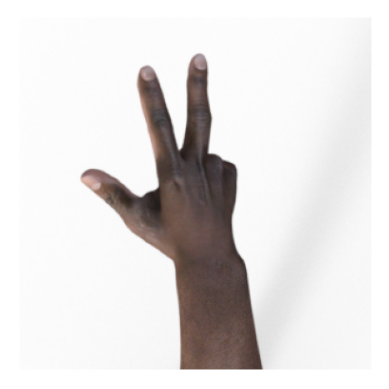

rock: 0.00%
paper: 0.00%
scissors: 100.00%

Final prediction: scissors


In [29]:
# 測試上傳的圖片
from google.colab import files
print("\nUpload an image to test:")
uploaded = files.upload()
for filename in uploaded.keys():
    print(f"\nPredicting {filename}:")
    prediction = predict_image(filename)
    print(f"\nFinal prediction: {prediction}")